### **DGM – BSM Forward CDF**

* **We solve the forward PDE for the cumulative distribution function (CDF)**
  under the Black-Scholes model using DGM

* **The PDE we solve is the backward Kolmogorov equation for the CDF**

  \begin{align*}
  \frac{\partial u}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 u}{\partial S^2} + \left( r - \frac{1}{2} \sigma^2 \right) S \frac{\partial u}{\partial S} = 0
  \end{align*}

  where $u(t, S, \sigma, S_T) = \mathbb{P}(S_T > S)$ is the CDF.

* **Terminal condition at $t = T$:**

  \begin{align*}
  u(T, S, \sigma, S_T) = \mathbf{1}_{S_T > S}
  \end{align*}

* **Inputs to the DGM network include:**
  $t$ (time), $S$ (underlying), $\sigma$ (volatility), and $S_T$ (target terminal value).

* **Loss function includes:**

  * PDE residual from the backward Kolmogorov equation
  * Mismatch at terminal time between model output and step function

* **Once trained, the CDF can be differentiated w\.r.t. $S_T$**
  to obtain the transition density function (PDF):

  \begin{align*}
  p(t, S; \sigma, S_T) = \frac{\partial u}{\partial S_T}
  \end{align*}




In [ ]:

import time, pathlib, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.autograd import grad

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# params
r          = 0.0
T_final    = 1.2
sigma_low, sigma_high = 0.0 , 0.6

# price domain  S ∈ [S_min , S_max]
S_min , S_max  = 0.05 , 20.0

# training hyper-params
batch_PDE  = 5_000
batch_term = 5_000
steps_per_sample = 5
sampling_stages  = 10000
λ_PDE   = 1                   # PDE loss weight
lr      = 1e-4

# DGM network
class DGMBlock(nn.Module):
    def __init__(self, in_dim: int, hidden: int):
        super().__init__()
        self.Uz, self.Wz = nn.Linear(in_dim, hidden), nn.Linear(hidden, hidden, bias=False)
        self.Ug, self.Wg = nn.Linear(in_dim, hidden), nn.Linear(hidden, hidden, bias=False)
        self.Ur, self.Wr = nn.Linear(in_dim, hidden), nn.Linear(hidden, hidden, bias=False)
        self.Uh, self.Wh = nn.Linear(in_dim, hidden), nn.Linear(hidden, hidden, bias=False)
    def forward(self, x, h):
        z = torch.sigmoid(self.Uz(x)+self.Wz(h))
        g = torch.sigmoid(self.Ug(x)+self.Wg(h))
        r = torch.sigmoid(self.Ur(x)+self.Wr(h))
        h_ = torch.tanh(self.Uh(x)+self.Wh(r*h))
        return (1-g)*h + g*h_

class DGMNet(nn.Module):
    def __init__(self, hidden=50, layers=3):
        super().__init__()
        self.inp   = nn.Linear(1+3, hidden)
        self.blocks= nn.ModuleList([DGMBlock(1+3, hidden) for _ in range(layers)])
        self.out   = nn.Linear(hidden, 1)
    def forward(self, t, x):
        z = torch.cat([t, x], 1)
        h = torch.tanh(self.inp(z))
        for blk in self.blocks:
            h = blk(z, h)
        return self.out(h)

net = DGMNet().to(device)
opt = optim.Adam(net.parameters(), lr=lr)

# Sampler

def sampler(nPDE: int, nT: int):
    # interior (PDE residual)
    t1  = torch.rand(nPDE,1,device=device)*T_final
    sig1= torch.rand(nPDE,1,device=device)*(sigma_high-sigma_low)+sigma_low
    S1  = torch.rand(nPDE,1,device=device)*(S_max-S_min)+S_min
    ST1 = torch.rand(nPDE,1,device=device)*(S_max-S_min)+S_min

    # terminal slice  t = T
    t2  = T_final*torch.ones(nT,1,device=device)
    sig2= torch.rand(nT,1,device=device)*(sigma_high-sigma_low)+sigma_low
    S2  = torch.rand(nT,1,device=device)*(S_max-S_min)+S_min
    ST2 = torch.rand(nT,1,device=device)*(S_max-S_min)+S_min
    return t1,sig1,S1,ST1,t2,sig2,S2,ST2

# loss function

def loss_fn(model, t1, σ1, S1, ST1, t2, σ2, S2, ST2):
    #  PDE residual
    x1 = torch.cat([σ1,S1,ST1],1).detach().clone().requires_grad_(True)
    t1r= t1.detach().clone().requires_grad_(True)

    V   = model(t1r, x1)
    V_t = grad(V, t1r, torch.ones_like(V), create_graph=True)[0]
    grads = grad(V, x1, torch.ones_like(V), create_graph=True)[0]
    V_S  = grads[:,1:2]
    V_SS = grad(V_S, x1, torch.ones_like(V_S), create_graph=True)[0][:,1:2]

    f = V_t + 0.5*σ1**2 * S1**2 * V_SS + (r-0.5*σ1**2)*S1 * V_S
    L1 = torch.mean(f**2)

    #  terminal residuals (indicator S_T > S)
    payoff = (ST2 > S2).float()
    V_T    = model(t2, torch.cat([σ2,S2,ST2],1))
    L2     = torch.mean((V_T - payoff)**2)
    return L1, L2

# training
print(f"Training on {device} …")
start = time.perf_counter()
for stage in range(1, sampling_stages+1):
    t1,σ1,S1,ST1,t2,σ2,S2,ST2 = sampler(batch_PDE, batch_term)
    for _ in range(steps_per_sample):
        opt.zero_grad()
        L1, L2 = loss_fn(net, t1,σ1,S1,ST1, t2,σ2,S2,ST2)
        total  = λ_PDE*L1 + L2
        total.backward()
        opt.step()

    if stage % 200 == 0:
        elapsed = time.perf_counter()-start
        print(f"stage {stage:05d} | tot {total.item():.2e} | L1 {L1.item():.2e} | L2 {L2.item():.2e} | {elapsed/stage:.3f}s/ep")

# Save
pathlib.Path("Results/BSM_price").mkdir(parents=True, exist_ok=True)
out_path = "Results/BSM_price/dgm_bsm_price_cdf.pth"
torch.save(net.state_dict(), out_path)
print("weights saved to", out_path)


Training on cuda …
stage 00200 | tot 3.36e-02 | L1 7.17e-03 | L2 2.65e-02 | 0.155s/ep
stage 00400 | tot 2.67e-02 | L1 5.93e-03 | L2 2.07e-02 | 0.155s/ep
stage 00600 | tot 2.11e-02 | L1 4.35e-03 | L2 1.68e-02 | 0.156s/ep
stage 00800 | tot 1.76e-02 | L1 3.47e-03 | L2 1.41e-02 | 0.156s/ep
stage 01000 | tot 1.43e-02 | L1 2.86e-03 | L2 1.14e-02 | 0.156s/ep
stage 01200 | tot 1.22e-02 | L1 2.66e-03 | L2 9.57e-03 | 0.155s/ep
stage 01400 | tot 1.08e-02 | L1 1.93e-03 | L2 8.85e-03 | 0.155s/ep
stage 01600 | tot 1.08e-02 | L1 1.89e-03 | L2 8.88e-03 | 0.155s/ep
stage 01800 | tot 9.12e-03 | L1 1.58e-03 | L2 7.54e-03 | 0.155s/ep
stage 02000 | tot 8.24e-03 | L1 1.78e-03 | L2 6.45e-03 | 0.155s/ep
stage 02200 | tot 7.96e-03 | L1 1.24e-03 | L2 6.72e-03 | 0.155s/ep
stage 02400 | tot 7.88e-03 | L1 1.01e-03 | L2 6.87e-03 | 0.155s/ep
stage 02600 | tot 7.53e-03 | L1 1.06e-03 | L2 6.47e-03 | 0.155s/ep
stage 02800 | tot 6.32e-03 | L1 1.33e-03 | L2 4.99e-03 | 0.155s/ep
stage 03000 | tot 6.15e-03 | L1 9.51e-04 | 

device: cuda
weights loaded ✔


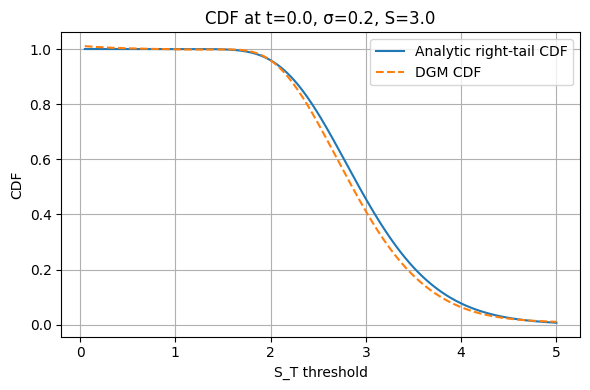

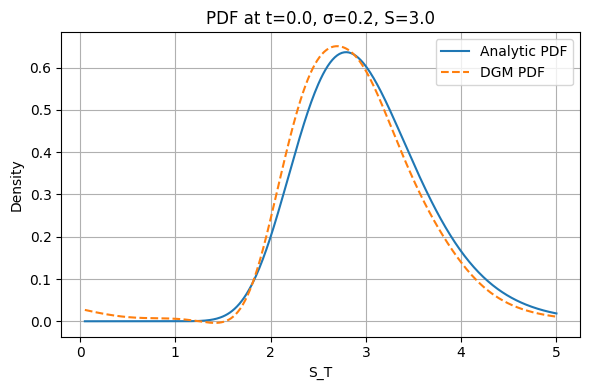

In [ ]:
import numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.autograd import grad
from math import sqrt, pi

# slice settings
SIGMA = 0.2
S0    = 3.0
T_NOW = 0.0
T_FIN = 1.2
R     = 0.0
ST_GRID = np.linspace(0.05, 5.0, 401, dtype=np.float32)

WEIGHT_PATH = "Results/BSM_price/dgm_bsm_price_cdf.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

#DGM
class DGMBlock(nn.Module):
    def __init__(self, k_in, k_h):
        super().__init__()
        self.Uz, self.Wz = nn.Linear(k_in,k_h), nn.Linear(k_h,k_h,bias=False)
        self.Ug, self.Wg = nn.Linear(k_in,k_h), nn.Linear(k_h,k_h,bias=False)
        self.Ur, self.Wr = nn.Linear(k_in,k_h), nn.Linear(k_h,k_h,bias=False)
        self.Uh, self.Wh = nn.Linear(k_in,k_h), nn.Linear(k_h,k_h,bias=False)
    def forward(self,x,h):
        z = torch.sigmoid(self.Uz(x)+self.Wz(h))
        g = torch.sigmoid(self.Ug(x)+self.Wg(h))
        r = torch.sigmoid(self.Ur(x)+self.Wr(h))
        h_ = torch.tanh(self.Uh(x)+self.Wh(r*h))
        return (1-g)*h + g*h_
class DGMNet(nn.Module):
    def __init__(self, hidden=50,layers=3):
        super().__init__()
        self.inp = nn.Linear(1+3, hidden)
        self.blocks = nn.ModuleList([DGMBlock(1+3,hidden) for _ in range(layers)])
        self.out = nn.Linear(hidden,1)
    def forward(self,t,x):
        z = torch.cat([t,x],1)
        h = torch.tanh(self.inp(z))
        for blk in self.blocks:
            h = blk(z,h)
        return self.out(h)

net = DGMNet().to(DEVICE)
net.load_state_dict(torch.load(WEIGHT_PATH, map_location=DEVICE))
net.eval(); print("weights loaded ✔")

# prep tensors
N = len(ST_GRID)
t_tensor  = torch.full((N,1), T_NOW, device=DEVICE)
sig_tensor= torch.full((N,1), SIGMA,  device=DEVICE)
S0_tensor = torch.full((N,1), S0,     device=DEVICE)
ST_tensor = torch.from_numpy(ST_GRID.copy()).view(-1,1).to(DEVICE)
ST_tensor.requires_grad_(True)
input_tensor = torch.cat([sig_tensor, S0_tensor, ST_tensor],1)

# net forward
with torch.enable_grad():
    cdf_left  = net(t_tensor, input_tensor)
    pdf_left  = grad(cdf_left, ST_tensor, torch.ones_like(cdf_left))[0]
    cdf_right = 1 - cdf_left
    pdf_right = -pdf_left

cdf_pred = cdf_right.detach().cpu().squeeze().numpy()
pdf_pred = -pdf_right.detach().cpu().squeeze().numpy()

tau = T_FIN - T_NOW
mu  = (R - 0.5*SIGMA**2)*tau
std = SIGMA*np.sqrt(tau)
ln_ST = np.log(ST_GRID); ln_S0 = np.log(S0)
z = (ln_ST - ln_S0 - mu)/std
Phi = 0.5*(1 + torch.erf(torch.from_numpy(z/np.sqrt(2))).numpy())
phi = np.exp(-0.5*z*z)/sqrt(2*pi)

cdf_true = 1 - Phi
pdf_true = phi / (ST_GRID*std)

plt.figure(figsize=(6,4))
plt.plot(ST_GRID, cdf_true, label="Analytic right‑tail CDF")
plt.plot(ST_GRID, cdf_pred, "--", label="DGM CDF")
plt.xlabel("S_T threshold"); plt.ylabel("CDF")
plt.title(f"CDF at t={T_NOW}, σ={SIGMA}, S={S0}")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(ST_GRID, pdf_true, label="Analytic PDF")
plt.plot(ST_GRID, pdf_pred, "--", label="DGM PDF")
plt.xlabel("S_T"); plt.ylabel("Density")
plt.title(f"PDF at t={T_NOW}, σ={SIGMA}, S={S0}")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


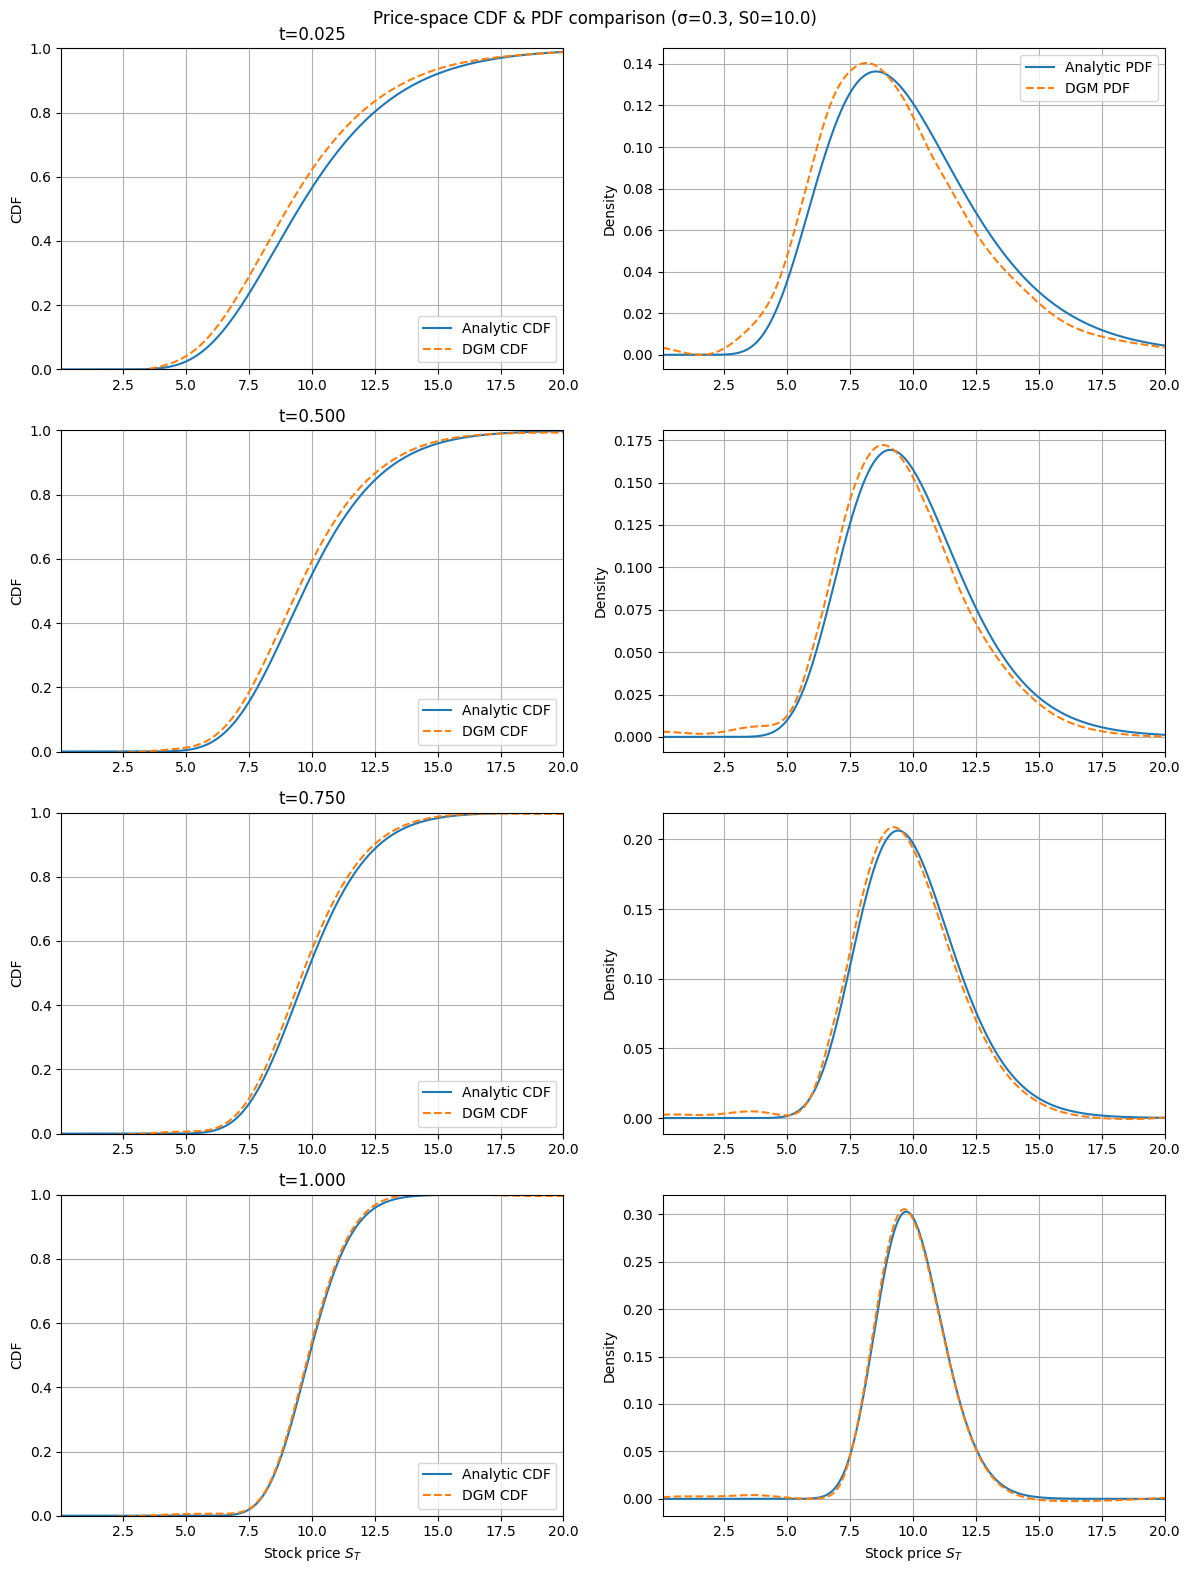

In [ ]:
import numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.autograd import grad
from math import sqrt, pi

net = DGMNet()
net.load_state_dict(torch.load("Results/BSM_price/dgm_bsm_price_cdf.pth", map_location="cpu"))
net.eval()

sigma = 0.3
S0    = 10.0
T_fin = 1.2
times = [0.025, 0.5, 0.75, 1]
S_min, S_max = 0.05, 20.0
S_grid = np.linspace(S_min, S_max, 601, dtype=np.float32)
N = len(S_grid)

def pdf_price(S, S0, sig, tau, r=0.0):
    mu  = (r - 0.5*sig**2)*tau
    std = sig*np.sqrt(tau)
    z   = (np.log(S) - np.log(S0) - mu)/std
    return np.exp(-0.5*z*z)/(S*std*sqrt(2*pi))

fig, axs = plt.subplots(len(times), 2, figsize=(12, 4*len(times)))

for row, t_now in enumerate(times):
    tau = T_fin - t_now
    t   = torch.full((N,1), t_now)
    sig = torch.full((N,1), sigma)
    S0t = torch.full((N,1), S0)
    ST  = torch.from_numpy(S_grid).view(-1,1).requires_grad_(True)
    x   = torch.cat([sig,S0t,ST],1)

    cdf_left = net(t,x)
    pdf_left = grad(cdf_left, ST, torch.ones_like(cdf_left))[0].detach().squeeze().numpy()
    cdf_left = cdf_left.detach().squeeze().numpy()

    pdf_true = pdf_price(S_grid, S0, sigma, tau)
    from math import erf
    pdf_true = pdf_price(S_grid, S0, sigma, tau)

    z = (np.log(S_grid) - np.log(S0) - (r-0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    cdf_true = 0.5 * (1 + torch.erf(torch.from_numpy(z/np.sqrt(2))).numpy())   # ← vectorised


    ax_c = axs[row,0] if len(times)>1 else axs[0]
    ax_c.plot(S_grid,cdf_true,label='Analytic CDF')
    ax_c.plot(S_grid,cdf_left,'--',label='DGM CDF')
    ax_c.set_xlim(S_min,S_max); ax_c.set_ylim(0,1)
    ax_c.set_ylabel('CDF'); ax_c.set_title(f't={t_now:.3f}')
    ax_c.grid(True); ax_c.legend(loc='lower right')

    ax_p = axs[row,1] if len(times)>1 else axs[1]
    ax_p.plot(S_grid,pdf_true,label='Analytic PDF')
    ax_p.plot(S_grid,pdf_left,'--',label='DGM PDF')
    ax_p.set_xlim(S_min,S_max)
    ax_p.set_ylabel('Density'); ax_p.grid(True)
    if row==0: ax_p.legend()

for ax in axs[-1]: ax.set_xlabel('Stock price $S_T$')
fig.suptitle(f'Price-space CDF & PDF comparison (σ={sigma}, S0={S0})', y=0.98)
plt.tight_layout()
plt.show()
